### Monitoring of the water extent of Lake Neusiedl and the Lacken:

#### Libraries

In [1]:
import os
import glob
from osgeo import gdal
import pprint
import numpy as np
import matplotlib.pyplot as plt
from yeoda.datacube import DataCubeReader,DataCubeWriter
from geopathfinder.naming_conventions.yeoda_naming import YeodaFilename
import pandas as pd
import time
import rasterio
import glob
from rasterio.plot import show
import rasterio
import numpy as np
from rasterio.merge import merge
from rasterio.plot import show
from osgeo import gdal
from data_func import  merge_files_and_split
import warnings
import numpy as np
import glob
from six.moves import xrange
import scipy.ndimage as ndi
import os
import tensorflow as tf
import torch 
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import img_to_array 
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2
import shutil
import albumentations as A

from PIL import Image, ImageOps, ImageFile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# pip install scipy
seed = 42
def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

set_seed(seed)

In [3]:

warnings.simplefilter(action='ignore', category=FutureWarning)




#### Reading Data

In [6]:
tile_1 = r"./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N015T1"
tile_1 = glob.glob(os.path.join(tile_1, "*"))

In [7]:
tile_2 = r"./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N015T1"
tile_2 = glob.glob(os.path.join(tile_2, "*"))

In [8]:

mask1 = r"./e11739391/reference/EQUI7_EU010M/E052N015T1"
mask1 = glob.glob(os.path.join(mask1, "*"))

mask2 = r"./e11739391/reference/EQUI7_EU010M/E053N015T1"
mask2 = glob.glob(os.path.join(mask2, "*"))

In [9]:

dimensions = ["time", "tile_name", "var_name", "sensor_field", "data_version"]
tile1_reader = DataCubeReader.from_filepaths(tile_1, fn_class=YeodaFilename, dimensions=dimensions,
                                             stack_dimension="time", tile_dimension="tile_name")
tile1_reader.file_register.head(5)

,filepath,data_version,var_name,tile_name,sensor_field,time
0,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,V1M0R01,GMR40,E053N015T1,S1AIWGRDH,2022-09-22 16:42:50
1,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,V1M0R01,GMR40,E053N015T1,S1AIWGRDH,2022-01-17 05:02:29
2,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,V1M0R01,GMR40,E053N015T1,S1AIWGRDH,2022-06-10 05:02:33
3,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,V1M0R01,GMR40,E053N015T1,S1AIWGRDH,2022-04-11 05:02:29
4,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,V1M0R01,GMR40,E053N015T1,S1AIWGRDH,2022-12-07 05:02:12


In [10]:

tile2_reader = DataCubeReader.from_filepaths(tile_2, fn_class=YeodaFilename, dimensions=dimensions,
                                             stack_dimension="time", tile_dimension="tile_name")
tile2_reader.file_register.head(5)

,filepath,data_version,var_name,tile_name,sensor_field,time
0,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,V1M0R01,GMR40,E052N015T1,S1AIWGRDH,2022-06-10 05:02:08
1,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,V1M0R01,GMR40,E052N015T1,S1AIWGRDH,2022-12-07 05:02:37
2,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,V1M0R01,GMR40,E052N015T1,S1AIWGRDH,2022-10-20 05:02:13
3,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,V1M0R01,GMR40,E052N015T1,S1AIWGRDH,2022-02-10 05:02:04
4,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,V1M0R01,GMR40,E052N015T1,S1AIWGRDH,2022-03-06 05:02:03


In [11]:
tile1_reader.file_register.sort_values(by = 'time')['time'].unique()

<DatetimeArray>
['2022-01-17 05:02:04', '2022-01-17 05:02:29', '2022-02-10 05:02:04',
 '2022-02-10 05:02:29', '2022-03-06 05:02:03', '2022-03-06 05:02:28',
 '2022-04-11 05:02:04', '2022-04-11 05:02:29', '2022-05-17 05:02:05',
 '2022-05-17 05:02:30', '2022-06-10 05:02:08', '2022-06-10 05:02:33',
 '2022-07-24 16:42:48', '2022-07-24 16:43:13', '2022-08-05 16:42:49',
 '2022-08-05 16:43:14', '2022-09-22 16:42:50', '2022-09-22 16:43:15',
 '2022-10-20 05:02:13', '2022-10-20 05:02:38', '2022-11-01 05:02:13',
 '2022-11-01 05:02:38', '2022-12-07 05:02:12', '2022-12-07 05:02:37']
Length: 24, dtype: datetime64[ns]

In [12]:
mask1_reader = DataCubeReader.from_filepaths(mask1, fn_class=YeodaFilename, dimensions=dimensions,
                                             stack_dimension="time", tile_dimension="tile_name")
mask2_reader = DataCubeReader.from_filepaths(mask2, fn_class=YeodaFilename, dimensions=dimensions,
                                             stack_dimension="time", tile_dimension="tile_name")

In [13]:
mask2_reader.file_register.head(5)

,filepath,data_version,var_name,tile_name,sensor_field,time
0,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,None,MASK,E053N015T1,None,2022-08-05
1,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,None,MASK,E053N015T1,None,2022-01-17
2,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,None,MASK,E053N015T1,None,2022-04-11
3,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,None,MASK,E053N015T1,None,2022-09-22
4,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,None,MASK,E053N015T1,None,2022-07-24


In [14]:
mask1_reader.file_register.head(5)

,filepath,data_version,var_name,tile_name,sensor_field,time
0,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,None,MASK,E052N015T1,None,2022-05-17
1,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,None,MASK,E052N015T1,None,2022-01-17
2,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,None,MASK,E052N015T1,None,2022-10-20
3,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,None,MASK,E052N015T1,None,2022-12-07
4,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,None,MASK,E052N015T1,None,2022-05-17


#### Merging files

In [15]:
df_concat = pd.concat([tile1_reader.file_register, tile2_reader.file_register], axis=0)

In [16]:
df_concat.head(5)

,filepath,sensor_field,data_version,var_name,tile_name,time
0,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,V1M0R01,GMR40,E053N015T1,2022-09-22 16:42:50
1,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,V1M0R01,GMR40,E053N015T1,2022-01-17 05:02:29
2,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,V1M0R01,GMR40,E053N015T1,2022-06-10 05:02:33
3,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,V1M0R01,GMR40,E053N015T1,2022-04-11 05:02:29
4,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,V1M0R01,GMR40,E053N015T1,2022-12-07 05:02:12


In [15]:
merge_files_and_split(df_concat,'VV')

/Users/nadia/PycharmProjects/InterdisciplinaryProject/data_func.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped.loc[:, 'date'] = grouped['time'].dt.date


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [16]:
merge_files_and_split(df_concat,'VH')

0

/Users/nadia/PycharmProjects/InterdisciplinaryProject/data_func.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped.loc[:, 'date'] = grouped['time'].dt.date


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [13]:
df_concat_mask= pd.concat([mask1_reader.file_register, mask2_reader.file_register], axis=0)

In [14]:
merge_files_and_split(df_concat_mask,notmask=False)

/Users/nadia/PycharmProjects/InterdisciplinaryProject/data_func.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped.loc[:, 'date'] = grouped['time'].dt.date


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...

### Reading merged data

In [55]:
path2 = "./train_mask/VV_mask_2022-01-17_merged.tiff"

In [56]:
path = "./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N015T1/GMR40_20220411T050204__VV_D124_E053N015T1_EU010M_V1M0R01_S1AIWGRDH.tif"



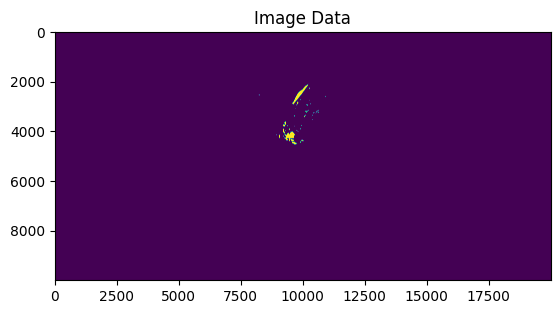

In [57]:
x =rasterio.open(path2)
image_data= x.read(1)
plt.imshow(image_data)
plt.title("Image Data")
plt.show()

In [43]:
x =rasterio.open(path2)
image_data= x.read(1)

In [44]:
image_data.shape

(10000, 20000)

In [107]:
# Image.MAX_IMAGE_PIXELS = None
# ImageFile.LOAD_TRUNCATED_IMAGES = True

In [16]:
train = "./train/*.tiff"
mask_train = "./train_mask/*.tiff"
img_list = sorted(glob.glob(train))
mask_list = sorted(glob.glob(mask_train))

In [17]:
file_num = len(img_list)
output_filename = './try.txt'
with open(output_filename, 'w') as f:
    for s in range(file_num):
        print(img_list[s][2:])
        f.write(img_list[s]+ '\t' + mask_list[s] + '\n' )

train/VH_2022-01-17_merged.tiff
train/VH_2022-02-10_merged.tiff
train/VH_2022-03-06_merged.tiff
train/VH_2022-06-10_merged.tiff
train/VH_2022-09-22_merged.tiff
train/VH_2022-10-20_merged.tiff
train/VH_2022-11-01_merged.tiff
train/VH_2022-12-07_merged.tiff
train/VV_2022-01-17_merged.tiff
train/VV_2022-02-10_merged.tiff
train/VV_2022-03-06_merged.tiff
train/VV_2022-06-10_merged.tiff
train/VV_2022-09-22_merged.tiff
train/VV_2022-10-20_merged.tiff
train/VV_2022-11-01_merged.tiff
train/VV_2022-12-07_merged.tiff


### Data Preparation

In [12]:
class ImageDataset(Dataset):
    def __init__(self, images_folder, mask_folder, transform=None):
        self.images = os.listdir(images_folder)
        self.images_folder = images_folder
        self.masks = os.listdir(mask_folder)
        self.transform = transform
        self.mask_folder = mask_folder

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_folder, self.images[idx])
        mask_path = os.path.join(self.mask_folder, self.masks[idx])
        image = rasterio.open(image_path).read(1)
        mask = rasterio.open(mask_path).read(1)

        image = np.array(image, dtype=np.float32) / 255.0
        mask = np.array(mask, dtype=np.float32) / 255.0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return torch.from_numpy(image).unsqueeze(0), torch.from_numpy(mask).unsqueeze(0)


In [13]:
train_batch_size =4
val_batch_size = 8
test_batch_size = 8



In [6]:
train_transform = A.Compose([A.Resize(256, 256), A.HorizontalFlip(p= 0.5), A.VerticalFlip(p= 0.5), A.RandomRotate90(p= 0.5)])

In [20]:
train_set = ImageDataset('./train/', './train_mask',train_transform )
val_set = ImageDataset(test_images, test_mask, )


In [21]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size= train_batch_size,shuffle= True)

In [23]:
for i, (images, masks) in enumerate(trainloader):
    print(images)
   


tensor([[[[-0.0492, -0.0197, -0.0336,  ..., -0.0451, -0.0524, -0.0313],
          [-0.0054, -0.0417, -0.0237,  ..., -0.0278, -0.0478, -0.0433],
          [-0.0480, -0.0514, -0.0364,  ..., -0.0314, -0.0196, -0.0188],
          ...,
          [-0.0593, -0.0314, -0.0248,  ..., -0.0249, -0.0293, -0.0380],
          [-0.0602, -0.0239,  0.0000,  ..., -0.0356, -0.0332, -0.0293],
          [-0.0565, -0.0759, -0.0089,  ..., -0.0281, -0.0271, -0.0317]]],


        [[[-0.0469, -0.0600, -0.0035,  ..., -0.0249, -0.0328, -0.0175],
          [-0.0578, -0.0360,  0.0059,  ..., -0.0259, -0.0149, -0.0237],
          [-0.0504, -0.0269, -0.0330,  ..., -0.0236, -0.0287, -0.0344],
          ...,
          [-0.0318, -0.0421, -0.0456,  ..., -0.0276, -0.0415, -0.0206],
          [-0.0153, -0.0361, -0.0299,  ..., -0.0317, -0.0553, -0.0384],
          [-0.0350, -0.0131, -0.0190,  ..., -0.0212, -0.0523, -0.0289]]],


        [[[-0.0762, -0.1018, -0.0162,  ..., -0.0508, -0.0566, -0.0622],
          [-0.0798, -0.052

In [29]:
print(trainloader)